### Solution developed by: Edoardo Bassett


# Question 1:
You are provided with data with 10-mins, 60-mins and 1-day resolution (Merge.csv). 

Please merge them into a pandas Dataframe with 2-hours resolution in between 7:00 – 17:00  only as index.  

Please take the average of the 10-mins and 60-mins resolution prices during the 2-hours  window and forward fill the 1-day resolution prices in the 2-hours window. 

## My interpretation of the questions:
To avoid ambiguity, here is my interpretation of the question. 

Initially, I was slighly confused by the wording as it appeared to indicate that the 1D resolution prices should be forward filled where the dates appear (or have values) in the 2H resolution dataframe. However, this cannot be the case, as when grouping the 2H DataFrame by 1D frequency, the NULL values happen in the same dates. Hence, I assumed that the forward fill should be only based on the current 1D values. However, this would remove the use of the 2H Dataframe.  

**Therefore, my interpretation of the question turned into the following:**

The question asks to create a Pandas DataFrame with 2-hours resolution with times from 07:00 to 17:00 as index. Effectively, as the resolution is 2H, the times being displayed will be between 07:00 and 15:00. The 2H resolution should be made of the average between the 10MIN resolution and the 1H resolution, in a 2H window. 

The question then asks to create 1D resolution prices based on the 2H DataFrame created. These values should be forward filled where NULL. The new values, should then be used as a replacement for the NULL values in the original 1D data. 

In [2]:
#import necessary libraries
import pandas as pd

In [3]:
#read dataframe
df = pd.read_csv('Merge.csv')
#convert datetime column to datetime. This will be useful later for frequency grouping.
df['Datetime'] = pd.to_datetime(df['Datetime'])
#create a 1H frequency DataFrame
hour_df = df[(df['Resolution'] == "1H")]
#create a 10MIN frequency DataFrame
minutes_df = df[(df['Resolution'] == "10MIN")]
#calculate the rolling average for 12 values (120 mins) on the 10MIN DF and only use the 2H intervals
mf = minutes_df.rolling(12, min_periods=1).mean().iloc[::12, :]
#calculate the rolling average for 2 values (2H) on the 1H DF and only use the 2H intervals
hf = hour_df.rolling(2, min_periods=1).mean().iloc[::2, :]
#get the relevant times
dt = minutes_df.iloc[::12, :]['Datetime']

In [16]:
# we now all have all the info for our new 2H dataframe. 
# However, we still need to average the 1H and 10MIN values for the 2H windows.
t = pd.DataFrame(data = {'Datetime': dt, '10MIN': mf.values[:, 0], '1HR': hf.values[:, 0]})

# We now calculate the average from these two columns
t['Price'] = t[['10MIN', '1HR']].mean(axis=1)
# Add a new 2H resolution column
t['Resolution'] = '2H'
# Drop the old columns
t = t.drop(['10MIN', '1HR'], axis=1)
# Sort the columns
t = t[['Datetime', 'Resolution', 'Price']]
#We now have our 2H resolution DF. 
# Let's only pick the times between 07:00 to 17:00, and set the index to our new datetime.
t = t.set_index('Datetime')
t = t.between_time('07:00','17:00')

t

,Resolution,Price
Datetime,,
2021-11-01 07:00:00,2H,70.662500
2021-11-01 09:00:00,2H,71.240000
2021-11-01 11:00:00,2H,70.541667
2021-11-01 13:00:00,2H,66.502083
2021-11-01 15:00:00,2H,63.918750
...,...,...
2021-11-30 07:00:00,2H,94.732955
2021-11-30 09:00:00,2H,98.145312
2021-11-30 11:00:00,2H,98.140625


In [17]:
# We now want to use the 1D averages from the 2H window to forward fill the 
# NULL values from the original data. 

#Let's reset the index from out previous 2H DF.
t = t.reset_index()
# Now, we group by 1D frequency and calculate its mean and forward fill.
t2 = t.groupby([pd.Grouper(freq='1D',key='Datetime')])['Price'].mean().ffill()
# We then use these values to fill the NULL values in our original 1D resolution prices
tmp = df.loc[(df.Resolution == 'D')]
tmp['Temp'] = t2.values
tmp['Price'] = tmp['Price'].fillna(tmp['Temp'])
tmp = tmp.drop(columns=['Temp'])
tmp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Resolution,Datetime,Price
1540,D,2021-11-01,66.100000
1541,D,2021-11-02,70.000000
1542,D,2021-11-03,78.375000
1543,D,2021-11-04,72.000000
1544,D,2021-11-05,72.500000
1545,D,2021-11-06,73.191193
1546,D,2021-11-07,73.191193
1547,D,2021-11-08,77.450000
1548,D,2021-11-09,70.400000
1549,D,2021-11-10,70.700000


In [19]:
# If we want to directly replace the values in our original df, we can do the following:
df.loc[df['Resolution'] == "D", 'Price'] = tmp['Price']

In [20]:
df

,Resolution,Datetime,Price
0,10MIN,2021-11-01 07:00:00,70.000000
1,10MIN,2021-11-01 07:10:00,NaN
2,10MIN,2021-11-01 07:20:00,71.500000
3,10MIN,2021-11-01 07:30:00,71.375000
4,10MIN,2021-11-01 07:40:00,NaN
...,...,...,...
1565,D,2021-11-26 00:00:00,88.350000
1566,D,2021-11-27 00:00:00,90.669186
1567,D,2021-11-28 00:00:00,90.669186
1568,D,2021-11-29 00:00:00,94.900000


## Question 2

You are provided with a daily energy consumption data from 2016 to date (Consumption.csv).  

Please create a Pandas DataFrame with to show the consumption of each year. 

The expected format  is to have the year number as column name and mm-dd as index. 

Please also create a seasonal plot showing 5-years (2016-2020) range (shaded) & average (dashed  line), and year 2021 (line) & 2022 (line). 

Please comment on your observation on the plot 


In [23]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta

In [22]:
# read the data
consumption_df = pd.read_csv('Consumption.csv')

In [24]:
# create a new set of dates to replace the unclean values in the dataframe
start_date = date(2016, 1, 1) 
end_date = date(2022, 10, 3)   

delta = end_date - start_date  

days = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    days.append(day)

In [25]:
# Create new year and mm-dd column
year_column = [day.year for day in days]
mm_dd_column = [str(day.month) + "-" + str(day.day) for day in days]

In [26]:
# create new processed dataframe setting mm-dd as index and adding the year column
processed_df = pd.DataFrame(data={'mm-dd': mm_dd_column, 'year': year_column, 'Consumption': consumption_df.Consumption.values })
processed_df = processed_df.set_index('mm-dd')       


In [27]:
# create dataframe for the data between 2016 and 2020
df_2016_2020 = processed_df[processed_df.year <= 2020].copy().reset_index()

In [28]:
# Create 2021 and 2022 dataframes, and rename the columns
df_2021 = processed_df[processed_df.year == 2021].copy().reset_index()
df_2022 = processed_df[processed_df.year == 2022].copy().reset_index()
df_2021 = df_2021.rename(columns={"Consumption": "2021"})
df_2022 = df_2022.rename(columns={"Consumption": "2022"})

In [36]:
# Create max, min and mean dataframes from the data from 2016 to 2022 
# to create the 5 year shaded range and its average 

In [29]:
max_df = df_2016_2020.groupby('mm-dd', sort=False)['Consumption'].max() 

In [31]:
min_df = df_2016_2020.groupby('mm-dd', sort=False)['Consumption'].min() 

In [30]:
mean_df = df_2016_2020.groupby('mm-dd', sort=False)['Consumption'].mean() 

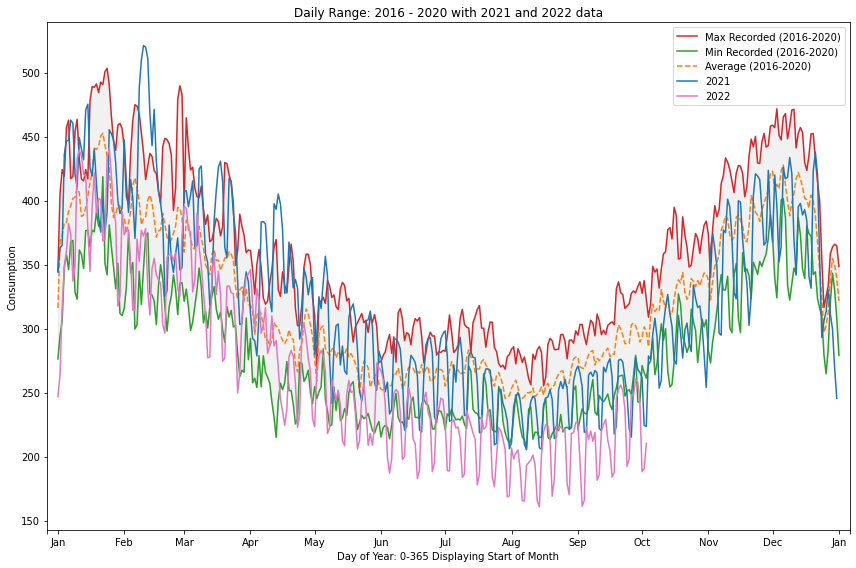

In [38]:
import calendar

# plot the data
ax = max_df.plot(label='Max Recorded (2016-2020)', color='tab:red', figsize=(12, 8))
min_df.plot(ax=ax, label='Min Recorded (2016-2020)', color='tab:green')
mean_df.plot(ax=ax, label='Average (2016-2020)', color='tab:orange', linestyle='dashed')
df_2021[['2021']].plot(ax=ax, label='2021', color='tab:blue')
df_2022[['2022']].plot(ax=ax, label='2022', color='tab:pink')

# add the fill, between min and max
plt.fill_between(max_df.index, max_df.values, min_df.values, alpha=0.10, color='tab:grey')
# set plot xlim
plt.xlim(-5, 370)

# tick locations
ticks=[-5, 0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365, 370]

# tick labels
labels = list(calendar.month_abbr)  # list of months
labels.extend(['Jan', ''])

# add the custom ticks and labels
plt.xticks(ticks=ticks, labels=labels)

# plot cosmetics
plt.legend()
plt.xlabel('Day of Year: 0-365 Displaying Start of Month')
plt.ylabel('Consumption')
plt.title('Daily Range: 2016 - 2020 with 2021 and 2022 data')
plt.tight_layout()
plt.show()

## My observations:
2021 Consumption seems to be higher than average in the first half of the year, but lower than average in the second half.
On the other hand, 2022 consumption seems to be consistently lower in the first half of the year, and completely goes below the minimum recorded since 2016 in the second half.

The seasons with the most energy consumption are clearly the coldest ones of the year: Autumn and Winter. 

I would expect the rest of 2022 to rise in energy consumption but still be significantly lower than the average, if not lower than the minimum recorded since 2016.

The significantly lower energy consumption could be related to the current events (War in Ukraine, increase of energy prices). 

The 2016-2020 range does seem to have only predictive indications for 1 year ahead. E.g. you could expect one-year ahead energy consumption prices to fall within the 2016-2020 range.

2 years ahead, and the informative relevance of the 2016-2020 range significantly drops.

There are significant intra-month spikes in consumption. This could be due to how the data is collected during week-days. 

## Question 3

A robot moves around a flat surface from position (0,0). 

It accepts instructions, and moves accordingly.  

For example: 
BEGIN 
LEFT 3 
UP 5 
RIGHT 4 
DOWN 7 

The first word indicates direction and the number shows steps. 
The robot will stop moving with instruction STOP.  

Please write a function, which accepts instructions as a list. When first “STOP” instruction is given, it  calculates the distance of Robot from the original position (0,0) 


In [47]:
'''
Assumptions:
- The distance to be calculated is the Euclidean Distance. 
- The possible instructions are: 'BEGIN', 'STOP', {i: i ∈ {'LEFT', 'RIGHT', 'UP', 'DOWN'}} SPACE {x: x ∈ R}. 
  These can only be valid instructions if formatted as such. 
  Invalid instructions will not have an effect on the position of the Robot.
- 'LEFT' indicates moving negatively on the x axis, 'RIGHT' positively. 
- 'UP' indicates moving positively on the y axis, 'DOWN' negatively. 
- Negative numbers are allowed, but they will have a reverse affect on the instruction. 'LEFT 20' = 'RIGHT -20'
- Instructions will be considered from the first 'BEGIN' to the first 'STOP'. 
  Any other instruction combination in the list will not be considered. 
'''

import math
def robo_distance(instructions: list):
  """
    Updates the position of the robot for each instruction
    and calculates its distance from the starting position at the first STOP instruction

    Parameters:
    instructions (list): a list of strings representing instructions for the robot
  """
  position = [0, 0]

  #formatting checks
  try:
    start_index = instructions.index('BEGIN')
    end_index = instructions.index('STOP')
    assert(start_index < end_index)
  except: 
    print("Instructions are not well formatted. Euclidean distance is 0")
    return
  # interpret instructions and add to the position of the robot
  for instruction in instructions:
    move = interpret(instruction)
    position[0] = position[0] + move[0]
    position[1] = position[1] + move[1]

  #Calculating the Euclidean distance. Do not need initial position for the purpose of this exercise as it is (0,0).
  print("Final position is: (", position[0], ", ", position[1], "). Euclidean Distance is ", math.sqrt(position[0]**2 + position[1]**2))
  
def interpret(instruction: str):
  """
    Interprets an instruction converting it to positions to add to the robot's current position.

    Parameters:
    instruction (str): an instruction

    Returns:
    list : [x, y] movement of the robot
  """
  try: 
    word, change = instruction.split(" ")
    change = float(change)
    if word == "LEFT": return [-change, 0]
    elif word == "RIGHT": return [change, 0]
    elif word == "UP": return [0, change]
    elif word == "DOWN": return [0, -change]
    else: return [0, 0] #Do not consider invalid instructions (NULL effect)
  except: #Instructions that do not have an effect on the position or are invalid
    return [0, 0] 

In [40]:
robo_distance(['BEGIN', 'UP 20', 'LEFT 20', 'RIGHT 20', 'STOP', 'STOP', 'BEGIN'])

Final position is: ( 0.0 ,  20.0 ). Euclidean Distance is  20.0


# Question 4:
You are provided with sample trades data in a data file (trades.csv). It contains a collection of trade  data during 5 working days with volume and price. 

You are asked to process the sample data into a  data set for creating the candlestick plots, with open, high, low & close prices (OHLC) and total volume  for each product and contract, over a time interval. 
You are expected to write a function to create a dataframe contains OHLC and trading volume with  (begin, end, product(s), freq) as input. It should be able take freq input, e.g., 15MIN, 1H, 1D.

Expected Result – A python model file detailing process with comments: 
Note:  
- The product “Emission - Venue A” and “Emission - Venue B” are the same product trading in  two different venues, please combine them when queried 
- If product list has more than one contract, please generate OHLC and volume data for each  contract 
- Please limit output within trading hours, i.e., 7:00 – 17:00, except when freq >= 1D
- Please do not use OHLC resampler

In [41]:
# import libraries
import pandas as pd
import re
from datetime import datetime
from dateutil import parser

In [48]:
def create_df(begin: str, end: str, products: list, frequency: str):
  """
    Creates an OHLC with volume dataframe from Trades.csv based on a certain frequency and within a certain range.
    Groups by contract.

    Parameters:
    begin (str): a begin date for the OHLC data
    end (str): an end date for the OHLC data
    products (list): a list of strings indicating the products for which we want the OHLC data
    frequency (str): a frequency string. Could be any frequency that respects Pandas' Grouper frequency format https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

    Returns:
    pd.DataFrame : processed dataframe with Datetime, OHLC and Volume.
  """
  #read data
  df = pd.read_csv('Trades.csv')
  #Convert TradeDateTime to actual datetime dtype
  df['TradeDateTime'] = pd.to_datetime(df['TradeDateTime'])

  #Convert begin and end variables to datetimes
  begin = parser.parse(begin).strftime("%Y-%m-%d %H:%M:%S")
  end = parser.parse(end).strftime("%Y-%m-%d %H:%M:%S")

  #filter dataframe between the two dates
  df = df[(df['TradeDateTime'] >= begin) & (df['TradeDateTime'] <= end)]

  #Check if frequency is more than 1 day (with regex for more flexibility). 
  # If it is, do all trading hours. 
  # If not, filter trading hours between 07:00 and 17:00
  r = re.compile("([0-9]+[.]?[0-9]*)[ \t]*([a-zA-Z]+)")
  m = r.match(frequency)
  if not (float(m.group(1)) >= 1 and (m.group(2)[0] == 'D' or m.group(2)[0] == 'd')):
    df = df.set_index('TradeDateTime')
    df = df.between_time('07:00','17:00')
    df = df.reset_index()

  #Emission - Venue A, Emission - Venue B are merged in an additional processed Product column 
  df['pProduct'] = df['Product']
  df['pProduct'] = df['pProduct'].replace(['Emission - Venue A', 'Emission - Venue B'], 'Emission - Venue AB')

  products = list(map(lambda x: x.replace('Emission - Venue A', 'Emission - Venue AB').replace('Emission - Venue B', 'Emission - Venue AB'), products))
  df = df[df['pProduct'].isin(products)]
  
  #create OHLC dataframe, with volume
  open = df.groupby([pd.Grouper(freq=frequency,key='TradeDateTime'), 'Contract'])['Price'].nth([0])
  close = df.groupby([pd.Grouper(freq=frequency,key='TradeDateTime'), 'Contract'])['Price'].nth([-1])
  high = df.groupby([pd.Grouper(freq=frequency,key='TradeDateTime'), 'Contract'])['Price'].max()
  low = df.groupby([pd.Grouper(freq=frequency,key='TradeDateTime'), 'Contract'])['Price'].min()
  volume = df.groupby([pd.Grouper(freq=frequency,key='TradeDateTime'), 'Contract'])['Quantity'].sum()
  processed_df = pd.concat([open, high, low, close, volume], axis=1).reset_index()
  processed_df = processed_df.set_axis(['TradeDateTime', 'Contract', 'Open', 'High', 'Low', 'Close', 'Volume'], axis=1)

  # return processed dataframe
  return processed_df
  

In [49]:
d = create_df('2022-04-18 00:37:00', '2023-05-18 00:54:00', ['Emission - Venue B'], '1D')
d

,TradeDateTime,Contract,Open,High,Low,Close,Volume
0,2022-04-18,DA,20.50000,20.70000,19.16250,19.75000,116130
1,2022-04-18,M01,19.20000,19.64000,18.81875,19.15000,6774
2,2022-04-19,DA,19.80000,20.50000,18.65000,19.10625,133817
3,2022-04-19,M01,20.25000,20.41750,18.45000,18.45000,11850
4,2022-04-20,DA,19.02500,19.26250,18.40000,18.87500,115897
5,2022-04-20,M01,18.36000,18.98500,18.09500,18.69750,8273
6,2022-04-21,DA,18.81250,19.22500,18.11875,18.30000,130342
7,2022-04-21,M01,18.98625,18.98625,17.84750,18.33750,8681


In [50]:
d = create_df('2022-04-18 00:37:00', '2023-05-18 00:54:00', ['Energy'], '17min')
d

,TradeDateTime,Contract,Open,High,Low,Close,Volume
0,2022-04-18 06:48:00,Q01,24.1550,24.1550,23.9425,23.9750,156
1,2022-04-18 07:05:00,Q01,23.9600,24.0425,23.8775,23.9350,527
2,2022-04-18 07:22:00,Q01,23.9375,24.0075,23.8875,23.9500,428
3,2022-04-18 07:39:00,Q01,23.9650,24.0700,23.9600,23.9725,333
4,2022-04-18 07:56:00,Q01,23.9725,24.0400,23.6500,23.7875,553
...,...,...,...,...,...,...,...
135,2022-04-21 15:50:00,Q01,22.5900,22.7000,22.4900,22.6975,851
136,2022-04-21 16:07:00,Q01,22.6875,22.8400,22.6475,22.8375,908
137,2022-04-21 16:24:00,Q01,22.8400,22.8625,22.7950,22.8425,592
138,2022-04-21 16:41:00,Q01,22.8625,22.8625,22.6875,22.7700,439
